In [1]:
import sys
import os
sys.path.append(os.path.join(r'D:\e-commerce_env\e-commerce\Lib\site-packages'))
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('data.csv',encoding= 'unicode_escape')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [8]:
df['StockCode'].value_counts()

85123A    2313
22423     2203
85099B    2159
47566     1727
20725     1639
          ... 
21431        1
22275        1
17001        1
90187A       1
72759        1
Name: StockCode, Length: 4070, dtype: int64

In [2]:
def transform_datatypes_and_nulls(df):
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
    df['CustomerID'].fillna(0,inplace=True)
    df['CustomerID'] = df['CustomerID'].astype(int)
    df['Quantity'] = df['Quantity'].astype(int)

def fill_null_values_in_descripctions(df):
    # Sort the DataFrame by 'StockCode' and 'InvoiceDate' to ensure rows with the same 'StockCode' are consecutive
    df.sort_values(by=['StockCode', 'InvoiceDate'], inplace=True)
    # Use forward-fill (ffill) to replace null values in 'Description' column
    df['Description'].fillna(method='ffill', inplace=True)
    
# all transactions which weren't normal orders, rather some fee payments etc.
def divide_uncommon_transactions(df):
    df_M = df[df['StockCode'] == 'M']
    df_DOT = df[df['StockCode'] == 'DOT']
    df_BANK_CHARGES = df[df['StockCode'] == 'BANK CHARGES']
    df_AMAZONFEE = df[df['StockCode'] == 'AMAZONFEE']
    df_BAD_DEBT = df[df['StockCode'] == "B"]
    df_POSTAGE = df[df['StockCode'] == "POST"]
    df_DISCOUNT = df[df['StockCode'] == "D"]
    df_CRUK_COMMISIONS = df[df['StockCode'] == "CRUK"]

    return {
        'M': df_M,
        'DOT': df_DOT,
        'BANK CHARGES': df_BANK_CHARGES,
        'AMAZONFEE': df_AMAZONFEE,
        'B': df_BAD_DEBT,
        'POST': df_POSTAGE,
        'D': df_DISCOUNT,
        'CRUK': df_CRUK_COMMISIONS
    }

def create_filtered_orders(df):
    mask = (df['StockCode'] != "AMAZONFEE") & (df['StockCode'] != "BANK CHARGES") & (df['StockCode'] != "M") & (df['StockCode'] != "DOT") & (df['StockCode'] != "B")& (df['StockCode'] != "POST") & (df['StockCode'] != "D") &(df['StockCode'] != "CRUK")
    filtered_df = df[mask]
    return filtered_df

# checking for all canceled orders 
def cancelled_orders(df):
    mask = df['InvoiceNo'].str.startswith('C')
    cancelled_orders = df[mask]
    return cancelled_orders

#items which are damaged, lost but they are not returns
def items_which_are_not_sellable():
    maska = filtered_df['InvoiceNo'].str.startswith('C')
    not_sellable_items = filtered_df[(maska==False) & (filtered_df['Quantity']<0)]
    return not_sellable_items

def remove_cancelled_lost_and_damaged_orders_from_filtered_df():
    new_df = filtered_df[(filtered_df['Quantity']<0)==False]
    return new_df

def create_df_with_manual_returns():
    df_M_returns = df_M[df_M['Quantity']<0]
    return df_M_returns

def add_full_items_price_to_df(df):
    df['FullPrice'] = df['Quantity'] * df['UnitPrice'] 

def delete_items_which_were_returned(filtered_df):
    matching_columns = ["Quantity", "StockCode", "UnitPrice", "CustomerID"]
    # Merge the dataframes based on the matching columns
    merged_df = filtered_df.merge(cancelled_orders_and_returns[matching_columns], how='left', indicator=True)
    # Filter out the rows that were present in both dataframes (returns)
    filtered_df1 = merged_df[merged_df['_merge'] != 'both']
    # Drop the indicator column
    filtered_df1.drop('_merge', axis=1, inplace=True)
    filtered_df1 = filtered_df1.reset_index(drop=True)
    return filtered_df1

def create_dataframe_with_sales_per_item():
    
    grouped = orders.groupby(['StockCode'])
    items_count = grouped['Quantity'].sum()
    product_total_prices = grouped['Quantity', 'UnitPrice'].apply(lambda x: (x['Quantity'] * x['UnitPrice']).sum())
    product_summary = pd.DataFrame({
        'TotalQuantitySold': items_count,
        'TotalPrice': product_total_prices
    }).reset_index()
    stockCode_to_desc = orders.set_index('StockCode')['Description'].to_dict()
    stockCode_to_unitprice = orders.set_index('StockCode')['UnitPrice'].to_dict()
    product_summary['Description'] = product_summary['StockCode'].map(stockCode_to_desc)
    product_summary['UnitPrice'] = product_summary['StockCode'].map(stockCode_to_unitprice)
    return product_summary

df = pd.read_csv('data.csv',encoding= 'unicode_escape')

transform_datatypes_and_nulls(df)
fill_null_values_in_descripctions(df)
df.sort_values(by=['InvoiceDate','InvoiceNo'],inplace=True)
df = df.reset_index(drop=True)

# Call the function and store the results in a dictionary
category_dataframes = divide_uncommon_transactions(df)

# Access each category's DataFrame
df_M = category_dataframes['M']
df_DOT = category_dataframes['DOT']
df_BANK_CHARGES = category_dataframes['BANK CHARGES']
df_AMAZONFEE = category_dataframes['AMAZONFEE']
df_BAD_DEBT = category_dataframes['B']
df_POSTAGE = category_dataframes['POST']
df_DISCOUNT = category_dataframes['D']
df_CRUK_COMMISIONS = category_dataframes['CRUK']
df_M_returns = create_df_with_manual_returns()
df_M = df_M[df_M['Quantity']>=0]

filtered_df = create_filtered_orders(df)
filtered_df = filtered_df.reset_index(drop=True)

cancelled_orders_and_returns = cancelled_orders(filtered_df)
not_sellable_items = items_which_are_not_sellable()
filtered_df = remove_cancelled_lost_and_damaged_orders_from_filtered_df()

add_full_items_price_to_df(filtered_df)
add_full_items_price_to_df(cancelled_orders_and_returns) 

# using abs() on full price and Quantity, so I'm being able to match it with orders from filtered_df
cancelled_orders_and_returns['FullPrice'] = cancelled_orders_and_returns['FullPrice'].apply(lambda x: abs(x))
cancelled_orders_and_returns['Quantity'] = cancelled_orders_and_returns['Quantity'].apply(lambda x: abs(x))

orders = delete_items_which_were_returned(filtered_df)
# there was still one small m so I moved it to the right place
orders[orders['StockCode']=='m']
df_M.append(orders.iloc[39109])
#dropping 1 result which is MANUAL and 1 anomaly which is just a noise 
orders = orders[orders['UnitPrice']!=0]

product_summary = create_dataframe_with_sales_per_item()
product_summary.sort_values(by=['TotalPrice'],ascending=False,inplace=True)
most_frequently_sold_items = product_summary.sort_values(by=['TotalQuantitySold'],ascending=False)
top_20_most_frequently_sold_items = most_frequently_sold_items[:20]
top_10_total_amount_items = product_summary[:10]

C:\Users\komputer\AppData\Local\Temp\ipykernel_22896\468987406.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df1.drop('_merge', axis=1, inplace=True)
C:\Users\komputer\AppData\Local\Temp\ipykernel_22896\468987406.py:128: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_M.append(orders.iloc[39109])
C:\Users\komputer\AppData\Local\Temp\ipykernel_22896\468987406.py:78: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  product_total_prices = grouped['Quantity', 'UnitPrice'].apply(lambda x: (x['Quantity'] * x['UnitPrice']).sum())


In [13]:
orders[orders['InvoiceNo']=='556418']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,FullPrice
214100,556418,47021G,SET/6 BEAD COASTERS GAUZE BAG GOLD,288,2011-06-10 12:26:00,0.0,0,United Kingdom,0.0


In [3]:
orders

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,FullPrice
0,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850,United Kingdom,25.50
1,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850,United Kingdom,15.30
2,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
3,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
523547,581587,22730,ALARM CLOCK BAKELIKE IVORY,4,2011-12-09 12:50:00,3.75,12680,France,15.00
523548,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,12.60
523549,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,16.60
523550,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,16.60


In [11]:
orders[orders['StockCode']=='47021G']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,FullPrice
5073,536846,47021G,SET/6 BEAD COASTERS GAUZE BAG GOLD,2,2010-12-02 19:59:00,1.25,14573,United Kingdom,2.50
13443,537434,47021G,SET/6 BEAD COASTERS GAUZE BAG GOLD,1,2010-12-06 16:57:00,5.06,0,United Kingdom,5.06
22537,538183,47021G,SET/6 BEAD COASTERS GAUZE BAG GOLD,12,2010-12-10 10:21:00,1.25,16265,United Kingdom,15.00
24023,538349,47021G,SET/6 BEAD COASTERS GAUZE BAG GOLD,1,2010-12-10 14:59:00,5.06,0,United Kingdom,5.06
24426,538356,47021G,SET/6 BEAD COASTERS GAUZE BAG GOLD,18,2010-12-10 15:56:00,1.25,14062,United Kingdom,22.50
27019,538566,47021G,SET/6 BEAD COASTERS GAUZE BAG GOLD,4,2010-12-13 11:21:00,5.06,0,United Kingdom,20.24
37682,539595,47021G,SET/6 BEAD COASTERS GAUZE BAG GOLD,1,2010-12-20 13:43:00,5.06,0,United Kingdom,5.06
51319,540821,47021G,SET/6 BEAD COASTERS GAUZE BAG GOLD,1,2011-01-11 13:16:00,5.06,0,United Kingdom,5.06
63352,541695,47021G,SET/6 BEAD COASTERS GAUZE BAG GOLD,1,2011-01-20 18:01:00,4.96,0,United Kingdom,4.96
90817,544323,47021G,SET/6 BEAD COASTERS GAUZE BAG GOLD,1,2011-02-17 15:51:00,4.96,0,United Kingdom,4.96


In [16]:
orders[orders['UnitPrice']==0].sort_values(by=['Quantity'])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,FullPrice
186487,553539,21922,UNION STRIPE WITH FRINGE HAMMOCK,1,2011-05-17 15:27:00,0.0,0,United Kingdom,0.0
408405,573169,35600A,Found by jackie,1,2011-10-28 09:56:00,0.0,0,United Kingdom,0.0
169019,551965,21429,RED GINGHAM ROSE JEWELLERY BOX,1,2011-05-05 13:13:00,0.0,0,United Kingdom,0.0
169018,551964,20851,ZINC HEART LATTICE TRAY OVAL,1,2011-05-05 13:13:00,0.0,0,United Kingdom,0.0
412981,573488,23400,check,1,2011-10-31 11:47:00,0.0,0,United Kingdom,0.0
...,...,...,...,...,...,...,...,...,...
111851,546139,84988,?,3000,2011-03-09 16:35:00,0.0,0,United Kingdom,0.0
254157,560040,23343,came coded as 20713,3100,2011-07-14 14:28:00,0.0,0,United Kingdom,0.0
212676,556231,85123A,?,4000,2011-06-09 15:04:00,0.0,0,United Kingdom,0.0
72181,542504,37413,PINK CHERRY BLOSSOM CUP & SAUCER,5568,2011-01-28 12:03:00,0.0,0,United Kingdom,0.0


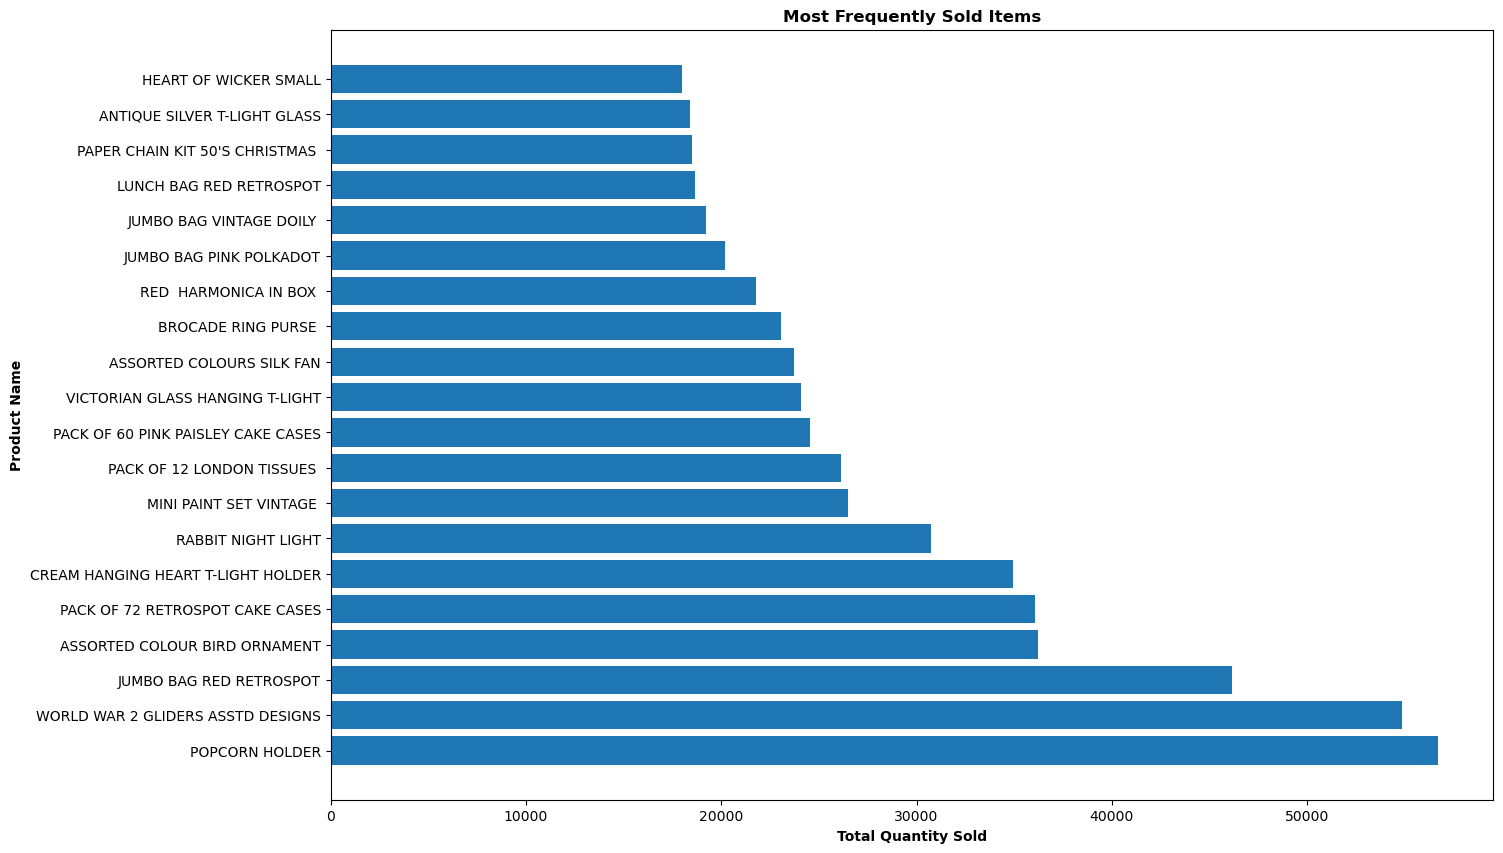

In [4]:
fig = plt.figure(figsize=(15,10))
plt.barh(y=top_20_most_frequently_sold_items["Description"],width=top_20_most_frequently_sold_items["TotalQuantitySold"])
plt.xlabel('Total Quantity Sold',fontweight='bold')
plt.ylabel('Product Name',fontweight='bold')
plt.title('Most Frequently Sold Items',fontweight='bold')
plt.savefig('Most_Freq_Items_Sold.png',bbox_inches='tight')

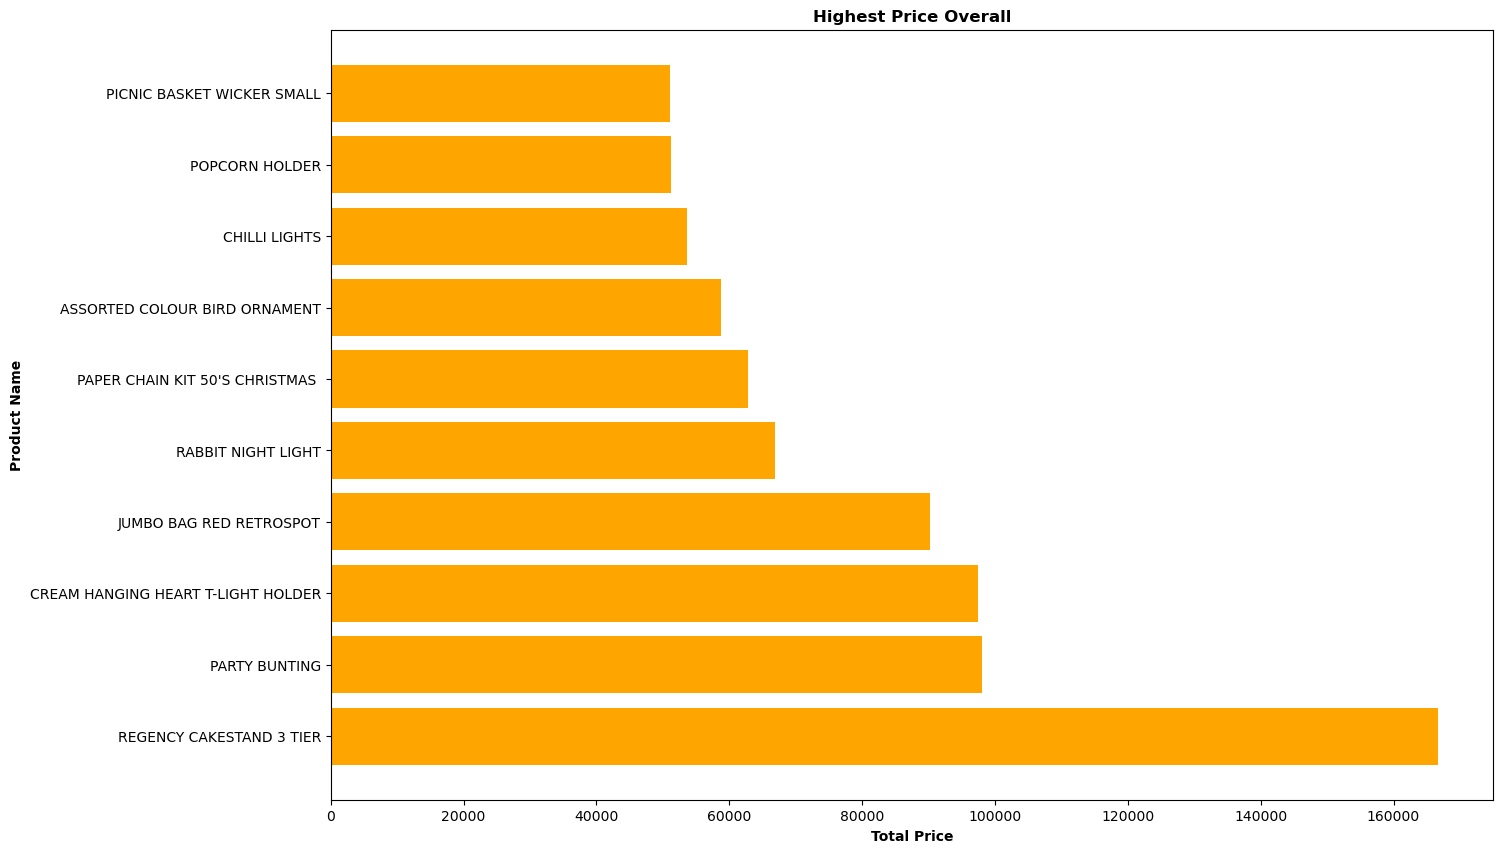

In [5]:
fig = plt.figure(figsize=(15,10))
plt.barh(y=top_10_total_amount_items["Description"],width=top_10_total_amount_items["TotalPrice"],color=['orange'])
plt.xlabel('Total Price',fontweight='bold')
plt.ylabel('Product Name',fontweight='bold')
plt.title('Highest Price Overall',fontweight='bold')
plt.savefig('Items_with_highest_total_price.png',bbox_inches='tight')

In [98]:
orders[orders['StockCode']=='84077'].value_counts()

InvoiceNo  StockCode  Description                        Quantity  InvoiceDate          UnitPrice  CustomerID  Country         FullPrice
570214     84077      WORLD WAR 2 GLIDERS ASSTD DESIGNS  96        2011-10-09 11:50:00  0.29       12748       United Kingdom  27.84        2
536615     84077      WORLD WAR 2 GLIDERS ASSTD DESIGNS  48        2010-12-02 10:09:00  0.29       14047       United Kingdom  13.92        1
568344     84077      WORLD WAR 2 GLIDERS ASSTD DESIGNS  48        2011-09-26 15:23:00  0.29       16531       United Kingdom  13.92        1
569087     84077      WORLD WAR 2 GLIDERS ASSTD DESIGNS  48        2011-09-30 12:03:00  0.29       13095       United Kingdom  13.92        1
569020     84077      WORLD WAR 2 GLIDERS ASSTD DESIGNS  48        2011-09-30 09:39:00  0.29       15321       United Kingdom  13.92        1
                                                                                                                                           ..
553472     

In [94]:
most_frequently_sold_items

,StockCode,TotalQuantitySold,TotalPrice,Description,UnitPrice
1111,22197,56684,51178.57,POPCORN HOLDER,0.85
2917,84077,54855,13786.17,WORLD WAR 2 GLIDERS ASSTD DESIGNS,0.63
3400,85099B,46177,90251.47,JUMBO BAG RED RETROSPOT,4.13
3420,85123A,38955,97499.25,CREAM HANGING HEART T-LIGHT HOLDER,2.95
3204,84879,36219,58685.95,ASSORTED COLOUR BIRD ORNAMENT,1.69
...,...,...,...,...,...
947,22016,1,83.33,Dotcomgiftshop Gift Voucher £100.00,83.33
3840,90187A,1,3.32,BLUE DROP EARRINGS W BEAD CLUSTER,3.32
2451,23643,1,3.33,SET 10 CARDS CHRISTMAS BAUBLE 16954,3.33
3419,85119,1,3.36,WATERING CAN SINGLE HOOK PISTACHIO,3.36


In [90]:
product_summary[:20]

,StockCode,TotalQuantitySold,TotalPrice,Description,UnitPrice
1312,22423,13205,166661.79,REGENCY CAKESTAND 3 TIER,24.96
2676,47566,17950,97976.78,PARTY BUNTING,10.79
3420,85123A,38955,97499.25,CREAM HANGING HEART T-LIGHT HOLDER,2.95
3400,85099B,46177,90251.47,JUMBO BAG RED RETROSPOT,4.13
1945,23084,31656,66827.71,RABBIT NIGHT LIGHT,2.08
1008,22086,18507,62786.69,PAPER CHAIN KIT 50'S CHRISTMAS,2.95
3204,84879,36219,58685.95,ASSORTED COLOUR BIRD ORNAMENT,1.69
2854,79321,10325,53662.26,CHILLI LIGHTS,5.75
1111,22197,56684,51178.57,POPCORN HOLDER,0.85
1386,22502,1975,51052.27,PICNIC BASKET WICKER SMALL,2.00


In [12]:
merged_df['_merge'].value_counts()

left_only     523552
both            5906
right_only         0
Name: _merge, dtype: int64

In [63]:
def create_dataframe_with_sales_per_item():
    
    grouped = orders.groupby(['StockCode'])
    items_count = grouped['Quantity'].sum()
    product_total_prices = grouped['Quantity', 'UnitPrice'].apply(lambda x: (x['Quantity'] * x['UnitPrice']).sum())
    product_summary = pd.DataFrame({
        'TotalQuantitySold': items_count,
        'TotalPrice': product_total_prices
    }).reset_index()
    stockCode_to_desc = orders.set_index('StockCode')['Description'].to_dict()


C:\Users\komputer\AppData\Local\Temp\ipykernel_16436\819847036.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  product_total_prices = grouped['Quantity', 'UnitPrice'].apply(lambda x: (x['Quantity'] * x['UnitPrice']).sum())


In [79]:
product_summary['Description'] = product_summary['StockCode'].map(stockCode_to_desc)

In [80]:
product_summary.

,StockCode,TotalQuantitySold,TotalPrice,Description
0,10002,1040,759.89,INFLATABLE POLITICAL GLOBE
1,10080,495,119.09,GROOVY CACTUS INFLATABLE
2,10120,193,40.53,DOGGY RUBBER
3,10123C,5,3.25,HEARTS WRAPPING TAPE
4,10124A,16,6.72,SPOTS ON RED BOOKCOVER TAPE
...,...,...,...,...
3925,gift_0001_10,39,74.97,Dotcomgiftshop Gift Voucher £10.00
3926,gift_0001_20,20,167.05,Dotcomgiftshop Gift Voucher £20.00
3927,gift_0001_30,37,175.53,Dotcomgiftshop Gift Voucher £30.00
3928,gift_0001_40,3,100.70,Dotcomgiftshop Gift Voucher £40.00


In [72]:
stockCode_to_desc = orders.set_index('StockCode')['Description'].to_dict()

In [75]:
stockCode_to_desc

{'21730': 'GLASS STAR FROSTED T-LIGHT HOLDER',
 '22752': 'SET 7 BABUSHKA NESTING BOXES',
 '71053': 'WHITE MOROCCAN METAL LANTERN',
 '84029E': 'RED WOOLLY HOTTIE WHITE HEART.',
 '84029G': 'KNITTED UNION FLAG HOT WATER BOTTLE',
 '84406B': 'CREAM CUPID HEARTS COAT HANGER',
 '85123A': 'CREAM HANGING HEART T-LIGHT HOLDER',
 '22633': 'HAND WARMER UNION JACK',
 '21754': 'HOME BUILDING BLOCK WORD',
 '21755': 'LOVE BUILDING BLOCK WORD',
 '21777': 'RECIPE BOX WITH METAL HEART',
 '22310': 'IVORY KNITTED MUG COSY ',
 '22622': 'BOX OF VINTAGE ALPHABET BLOCKS',
 '22623': 'BOX OF VINTAGE JIGSAW BLOCKS ',
 '22745': "POPPY'S PLAYHOUSE BEDROOM ",
 '22748': "POPPY'S PLAYHOUSE KITCHEN",
 '22749': 'FELTCRAFT PRINCESS CHARLOTTE DOLL',
 '48187': 'DOORMAT NEW ENGLAND',
 '84879': 'ASSORTED COLOUR BIRD ORNAMENT',
 '84969': 'BOX OF 6 ASSORTED COLOUR TEASPOONS',
 '22912': 'YELLOW COAT RACK PARIS FASHION',
 '22913': 'RED COAT RACK PARIS FASHION',
 '22914': 'BLUE COAT RACK PARIS FASHION',
 '22960': 'JAM MAKING SET 

In [7]:
cancelled_orders_and_returns[cancelled_orders_and_returns['CustomerID']==17548]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,FullPrice
233,C536391,21484,CHICK GREY HOT WATER BOTTLE,12,2010-12-01 10:24:00,3.45,17548,United Kingdom,41.40
234,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,24,2010-12-01 10:24:00,0.29,17548,United Kingdom,6.96
235,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,24,2010-12-01 10:24:00,0.29,17548,United Kingdom,6.96
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,24,2010-12-01 10:24:00,0.29,17548,United Kingdom,6.96
237,C536391,22553,PLASTERS IN TIN SKULLS,24,2010-12-01 10:24:00,1.65,17548,United Kingdom,39.60
238,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,12,2010-12-01 10:24:00,1.65,17548,United Kingdom,19.80
239,C536391,22557,PLASTERS IN TIN VINTAGE PAISLEY,12,2010-12-01 10:24:00,1.65,17548,United Kingdom,19.80
176292,C552049,22079,RIBBON REEL HEARTS DESIGN,10,2011-05-06 10:00:00,1.65,17548,United Kingdom,16.50
176293,C552049,22081,RIBBON REEL FLORA + FAUNA,10,2011-05-06 10:00:00,1.65,17548,United Kingdom,16.50
176294,C552049,22082,RIBBON REEL STRIPES DESIGN,10,2011-05-06 10:00:00,1.65,17548,United Kingdom,16.50


In [6]:
filtered_df[filtered_df['CustomerID']==17548]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,FullPrice
164164,550755,22079,RIBBON REEL HEARTS DESIGN,10,2011-04-20 12:01:00,1.65,17548,United Kingdom,16.5
164165,550755,22081,RIBBON REEL FLORA + FAUNA,10,2011-04-20 12:01:00,1.65,17548,United Kingdom,16.5
164166,550755,22082,RIBBON REEL STRIPES DESIGN,10,2011-04-20 12:01:00,1.65,17548,United Kingdom,16.5
164167,550755,22585,PACK OF 6 BIRDY GIFT TAGS,24,2011-04-20 12:01:00,1.25,17548,United Kingdom,30.0
164168,550755,22926,IVORY GIANT GARDEN THERMOMETER,4,2011-04-20 12:01:00,5.95,17548,United Kingdom,23.8


In [24]:
maska = filtered_df['InvoiceNo'].str.startswith('C')
filtered_df[(maska==False) & (filtered_df['Quantity']<0)]

0    1336
Name: CustomerID, dtype: int64

In [17]:
cancelled_orders_and_returns[cancelled_orders_and_returns['CustomerID']==17548]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,FullPrice,AbsQuantity
1,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,2010-12-01 10:24:00,3.45,17548,United Kingdom,41.40,12
2,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom,6.96,24
3,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom,6.96,24
4,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom,6.96,24
5,C536391,22553,PLASTERS IN TIN SKULLS,-24,2010-12-01 10:24:00,1.65,17548,United Kingdom,39.60,24
6,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom,19.80,12
7,C536391,22557,PLASTERS IN TIN VINTAGE PAISLEY,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom,19.80,12
3093,C552049,22079,RIBBON REEL HEARTS DESIGN,-10,2011-05-06 10:00:00,1.65,17548,United Kingdom,16.50,10
3094,C552049,22081,RIBBON REEL FLORA + FAUNA,-10,2011-05-06 10:00:00,1.65,17548,United Kingdom,16.50,10
3095,C552049,22082,RIBBON REEL STRIPES DESIGN,-10,2011-05-06 10:00:00,1.65,17548,United Kingdom,16.50,10


In [16]:
df[df['CustomerID']==17548]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
235,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,2010-12-01 10:24:00,3.45,17548,United Kingdom
236,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
238,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
239,C536391,22553,PLASTERS IN TIN SKULLS,-24,2010-12-01 10:24:00,1.65,17548,United Kingdom
240,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
241,C536391,22557,PLASTERS IN TIN VINTAGE PAISLEY,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
165024,550755,22079,RIBBON REEL HEARTS DESIGN,10,2011-04-20 12:01:00,1.65,17548,United Kingdom
165025,550755,22081,RIBBON REEL FLORA + FAUNA,10,2011-04-20 12:01:00,1.65,17548,United Kingdom
165026,550755,22082,RIBBON REEL STRIPES DESIGN,10,2011-04-20 12:01:00,1.65,17548,United Kingdom


In [4]:
cancelled_orders_and_returns

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
1,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,2010-12-01 10:24:00,3.45,17548,United Kingdom
2,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
3,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
4,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
...,...,...,...,...,...,...,...,...
9006,C580263,M,Manual,-16,2011-12-02 12:43:00,0.29,12536,France
9007,C580510,M,Manual,-1,2011-12-04 13:48:00,1.25,14456,United Kingdom
9008,C581009,M,Manual,-1,2011-12-07 09:15:00,125.00,16971,United Kingdom
9009,C581145,M,Manual,-1,2011-12-07 13:48:00,9.95,17490,United Kingdom


In [21]:
df_M_returns = df_M[df_M['Quantity']<0]

In [9]:
df_M.sort_values(by=['UnitPrice'],ascending=False).head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
222681,C556445,M,Manual,-1,2011-06-10 15:31:00,38970.00,15098,United Kingdom
173391,C551699,M,Manual,-1,2011-05-03 14:12:00,6930.00,16029,United Kingdom
268028,560373,M,Manual,1,2011-07-18 12:30:00,4287.63,0,United Kingdom
268027,C560372,M,Manual,-1,2011-07-18 12:26:00,4287.63,17448,United Kingdom
422375,C573079,M,Manual,-2,2011-10-27 14:15:00,4161.06,12536,France
422376,573080,M,Manual,1,2011-10-27 14:20:00,4161.06,12536,France
422351,573077,M,Manual,1,2011-10-27 14:13:00,4161.06,12536,France
406406,571751,M,Manual,1,2011-10-19 11:18:00,3949.32,12744,Singapore
406404,C571750,M,Manual,-1,2011-10-19 11:16:00,3949.32,12744,Singapore
293842,C562647,M,Manual,-1,2011-08-08 12:56:00,3155.95,15502,United Kingdom


In [11]:
maska = cancelled_orders_and_returns['InvoiceNo'].str.startswith('C')==False
cancelled_orders_and_returns[maska]['Quantity'].value_counts()

-1       79
-2       58
-5       46
-3       39
-6       36
         ..
-116      1
-304      1
-272      1
-1206     1
-235      1
Name: Quantity, Length: 298, dtype: int64

In [21]:
filtered_df[filtered_df['InvoiceNo']=='536996']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
7165,536996,22712,CARD DOLLY GIRL,-20,2010-12-03 15:30:00,0.0,0,United Kingdom


In [5]:
df_POSTAGE.sort_values(by=['UnitPrice'])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
52262,540699,POST,POSTAGE,1000,2011-01-11 09:32:00,0.00,0,United Kingdom
326552,565556,POST,POSTAGE,750,2011-09-05 12:14:00,0.00,0,United Kingdom
205991,554857,POST,POSTAGE,800,2011-05-27 10:08:00,0.00,0,United Kingdom
453998,575505,POST,POSTAGE,800,2011-11-10 10:29:00,0.00,0,United Kingdom
431374,573589,POST,POSTAGE,1,2011-10-31 15:11:00,0.55,0,United Kingdom
...,...,...,...,...,...,...,...,...
235379,C557638,POST,POSTAGE,-1,2011-06-21 16:01:00,545.58,17450,United Kingdom
264976,560187,POST,POSTAGE,1,2011-07-15 12:05:00,550.94,17444,Canada
236402,557754,POST,POSTAGE,1,2011-06-22 13:12:00,700.00,12432,Norway
173277,C551685,POST,POSTAGE,-1,2011-05-03 12:51:00,8142.75,16029,United Kingdom


In [28]:
cancelled_orders_and_returns[cancelled_orders_and_returns['CustomerID']==14527]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
148506,C549288,22469,HEART OF WICKER SMALL,-1,2011-04-07 18:06:00,1.65,14527,United Kingdom
148507,C549288,22788,BROCANTE COAT RACK,-1,2011-04-07 18:06:00,9.95,14527,United Kingdom
224637,C556735,22169,FAMILY ALBUM WHITE PICTURE FRAME,-2,2011-06-14 12:01:00,8.50,14527,United Kingdom


In [25]:
df_DISCOUNT

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
9038,C537164,D,Discount,-1,2010-12-05 13:21:00,29.29,14527,United Kingdom
14498,C537597,D,Discount,-1,2010-12-07 12:34:00,281.00,15498,United Kingdom
19392,C537857,D,Discount,-1,2010-12-08 16:00:00,267.12,17340,United Kingdom
31134,C538897,D,Discount,-1,2010-12-15 09:14:00,5.76,16422,United Kingdom
...,...,...,...,...,...,...,...,...
479868,C577227,D,Discount,-1,2011-11-18 12:06:00,19.82,14527,United Kingdom
479869,C577227,D,Discount,-1,2011-11-18 12:06:00,16.76,14527,United Kingdom
493613,C578239,D,Discount,-1,2011-11-23 12:29:00,26.33,14912,Italy
516221,C579884,D,Discount,-1,2011-11-30 17:34:00,20.53,14527,United Kingdom


In [6]:
quantity_stats = orders['Quantity'].describe()
unit_price_stats = orders['UnitPrice'].describe()
print("Quantity Statistics:")
print(quantity_stats)

print("\nUnitPrice Statistics:")
print(unit_price_stats)

Quantity Statistics:
count    522386.000000
mean         10.157142
std          36.614643
min           1.000000
25%           1.000000
50%           3.000000
75%          10.000000
max        4800.000000
Name: Quantity, dtype: float64

UnitPrice Statistics:
count    522386.000000
mean          3.255053
std           4.309111
min           0.001000
25%           1.250000
50%           2.080000
75%           4.130000
max         649.500000
Name: UnitPrice, dtype: float64


In [6]:
orders[orders['StockCode']=='37413']['UnitPrice'].value_counts()

0.39    81
1.25     2
0.00     1
Name: UnitPrice, dtype: int64

In [33]:
orders[orders['CustomerID']==13256]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,FullPrice
484618,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,2011-11-25 15:57:00,0.0,13256,United Kingdom,0.0


In [7]:
orders[orders['Quantity']==orders['Quantity'].max()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,FullPrice
406183,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,2011-10-27 12:26:00,0.21,12901,United Kingdom,1008.0


In [11]:
filtered_df[filtered_df['Quantity']==filtered_df['Quantity'].max()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
537725,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446,United Kingdom


In [12]:
filtered_df[filtered_df['Quantity']==filtered_df['Quantity'].min()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
537726,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2011-12-09 09:27:00,2.08,16446,United Kingdom


In [11]:
filtered_df['StockCode'].value_counts()

85123A    2313
22423     2203
85099B    2159
47566     1727
20725     1639
          ... 
85160a       1
62095B       1
85018C       1
84670        1
21653        1
Name: StockCode, Length: 4062, dtype: int64

In [12]:
filtered_df[(filtered_df['InvoiceDate']>'2010-12-01 09:00:00') & (filtered_df['InvoiceDate']<'2010-12-01 09:50:00') & (filtered_df['CustomerID']==15311)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
105,536381,15056BL,EDWARDIAN PARASOL BLACK,2,2010-12-01 09:41:00,5.95,15311,United Kingdom
106,536381,15056N,EDWARDIAN PARASOL NATURAL,2,2010-12-01 09:41:00,5.95,15311,United Kingdom
107,536381,21166,COOK WITH WINE METAL SIGN,1,2010-12-01 09:41:00,1.95,15311,United Kingdom
108,536381,21169,YOU'RE CONFUSING ME METAL SIGN,3,2010-12-01 09:41:00,1.69,15311,United Kingdom
109,536381,21175,GIN + TONIC DIET METAL SIGN,2,2010-12-01 09:41:00,2.10,15311,United Kingdom
110,536381,21523,DOORMAT FANCY FONT HOME SWEET HOME,10,2010-12-01 09:41:00,6.75,15311,United Kingdom
111,536381,21533,RETROSPOT LARGE MILK JUG,1,2010-12-01 09:41:00,4.95,15311,United Kingdom
112,536381,21557,SET OF 6 FUNKY BEAKERS,2,2010-12-01 09:41:00,2.95,15311,United Kingdom
113,536381,21672,WHITE SPOT RED CERAMIC DRAWER KNOB,6,2010-12-01 09:41:00,1.25,15311,United Kingdom
114,536381,21731,RED TOADSTOOL LED NIGHT LIGHT,2,2010-12-01 09:41:00,1.65,15311,United Kingdom


In [61]:
filtered_df[filtered_df['InvoiceNo'].str.startswith('C')==True]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
...,...,...,...,...,...,...,...,...
540448,C581490,22178,VICTORIAN GLASS HANGING T-LIGHT,-12,2011-12-09 09:57:00,1.95,14397,United Kingdom
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315,United Kingdom


In [ ]:
filtered_df

In [46]:
cancelled_orders

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315,United Kingdom


In [44]:
filtered_df[filtered_df['InvoiceNo']=='C536379']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


In [9]:
# countries which buy the most 

def create_country_orders_tuples():
    country_order_counts = orders['Country'].value_counts()
    country_order_tuples = [(country, count) for country, count in country_order_counts.items() if (country !='Unspecified') and (country!= 'Channel Islands')]
    return country_order_tuples

def map_countries_with_codes(country_order_tuples):

    country_codes = {
        'United Kingdom': 'gb',
        'Germany': 'de',
        'France': 'fr',
        'EIRE': 'ie',
        'Spain': 'es',
        'Netherlands': 'nl',
        'Belgium': 'be',
        'Switzerland': 'ch',
        'Portugal': 'pt',
        'Australia': 'au',
        'Norway': 'no',
        'Italy': 'it',
        'Finland': 'fi',
        'Cyprus': 'cy',
        'Sweden': 'se',
        'Austria': 'at',
        'Denmark': 'dk',
        'Japan': 'jp',
        'Poland': 'pl',
        'Israel': 'il',
        'USA': 'us',
        'Hong Kong': 'hk',
        'Singapore': 'sg',
        'Iceland': 'is',
        'Canada': 'ca',
        'Greece': 'gr',
        'Malta': 'mt',
        'United Arab Emirates': 'ae',
        'European Community': 'eu',
        'RSA': 'za',
        'Lebanon': 'lb',
        'Lithuania': 'lt',
        'Brazil': 'br',
        'Czech Republic': 'cz',
        'Bahrain': 'bh',
        'Saudi Arabia': 'sa'
    }   
    country_order_tuples_with_codes = [
        (country_codes.get(country, country), order) for country, order in country_order_tuples
    ]  
    return country_order_tuples_with_codes

In [13]:
# values wich can't be showed on the map
unsepcifed_country = [('unspecified',446)]
channel_islands_orders = [('Channel Islands',756)]

country_order_tuples = create_country_orders_tuples()
country_order_tuples_with_codes = map_countries_with_codes(country_order_tuples)

In [14]:
country_order_tuples_with_codes

[('gb', 479480),
 ('de', 8565),
 ('fr', 7982),
 ('ie', 7445),
 ('es', 2393),
 ('nl', 2314),
 ('be', 1928),
 ('ch', 1926),
 ('pt', 1458),
 ('au', 1109),
 ('no', 1032),
 ('it', 723),
 ('fi', 647),
 ('cy', 609),
 ('se', 421),
 ('at', 384),
 ('dk', 364),
 ('pl', 322),
 ('jp', 319),
 ('il', 295),
 ('hk', 275),
 ('sg', 215),
 ('is', 182),
 ('ca', 150),
 ('gr', 142),
 ('mt', 107),
 ('ae', 67),
 ('us', 67),
 ('eu', 57),
 ('za', 57),
 ('lb', 45),
 ('lt', 35),
 ('br', 32),
 ('cz', 23),
 ('bh', 17),
 ('sa', 9)]

In [15]:
country_order_tuples_with_codes_without_uk= [('de', 8565),
 ('fr', 7982),
 ('ie', 7445),
 ('es', 2393),
 ('nl', 2314),
 ('be', 1928),
 ('ch', 1926),
 ('pt', 1458),
 ('au', 1109),
 ('no', 1032),
 ('it', 723),
 ('fi', 647),
 ('cy', 609),
 ('se', 421),
 ('at', 384),
 ('dk', 364),
 ('pl', 322),
 ('jp', 319),
 ('il', 295),
 ('hk', 275),
 ('sg', 215),
 ('is', 182),
 ('ca', 150),
 ('gr', 142),
 ('mt', 107),
 ('ae', 67),
 ('us', 67),
 ('eu', 57),
 ('za', 57),
 ('lb', 45),
 ('lt', 35),
 ('br', 32),
 ('cz', 23),
 ('bh', 17),
 ('sa', 9)]

In [16]:
from pygal_maps_world.maps import World
def create_interactive_map_and_save_as_file():
    worldmap_chart = World()
    worldmap_chart.title = 'Number of orders based on Country'
    worldmap_chart.add('In 2010-2011',country_order_tuples_with_codes_without_uk)
    worldmap_chart.render_to_file('countries_map.svg')

create_interactive_map_and_save_as_file()

In [51]:
grouped_by_customer = filtered_df.groupby('CustomerID')

In [53]:
grouped_by_customer
average_order_size_per_customer = grouped_by_customer['Quantity'].mean()

In [61]:
average_order_size_per_customer.sort_values()

CustomerID
17307     -144.000000
16742      -63.333333
14213      -48.800000
12666      -28.000000
15638      -26.000000
             ...     
14609     1756.500000
16308     2000.000000
16754     2140.000000
13135     4300.000000
13256    12540.000000
Name: Quantity, Length: 4364, dtype: float64

In [25]:
filtered_df[filtered_df['Quantity']<0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
152,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
233,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,2010-12-01 10:24:00,3.45,17548,United Kingdom
234,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
235,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
...,...,...,...,...,...,...,...,...
537752,C581490,22178,VICTORIAN GLASS HANGING T-LIGHT,-12,2011-12-09 09:57:00,1.95,14397,United Kingdom
537753,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397,United Kingdom
539014,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311,United Kingdom
539015,C581569,20979,36 PENCILS TUBE RED RETROSPOT,-5,2011-12-09 11:58:00,1.25,17315,United Kingdom
